In [113]:
# !python column_explain.py [...]

In [1]:
import sphinx as spx
import mlflow
import shap

from random import choices
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

In [2]:
df_train = pd.read_csv("csv/application_train_imputed_a.csv")
df_train.drop(columns='Unnamed: 0', inplace=True)

df_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002.0,1.0,Cash loans,M,N,Y,0.0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
1,100003.0,0.0,Cash loans,F,N,N,0.0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,100004.0,0.0,Revolving loans,M,Y,Y,0.0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,100006.0,0.0,Cash loans,F,N,Y,0.0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.006746,0.007271,0.040146,0.239085,0.266575,2.056166
4,100007.0,0.0,Cash loans,M,N,Y,0.0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251.0,0.0,Cash loans,M,N,N,0.0,157500.0,254700.0,27558.0,...,0.0,0.0,0.0,0.0,0.015172,0.015940,0.052451,0.555239,0.241304,1.568782
307507,456252.0,0.0,Cash loans,F,N,Y,0.0,72000.0,269550.0,12001.5,...,0.0,0.0,0.0,0.0,0.005255,0.005464,0.035436,0.166527,0.286995,2.098052
307508,456253.0,0.0,Cash loans,F,N,Y,0.0,153000.0,677664.0,29979.0,...,0.0,0.0,0.0,0.0,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000
307509,456254.0,1.0,Cash loans,F,N,Y,0.0,171000.0,370107.0,20205.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


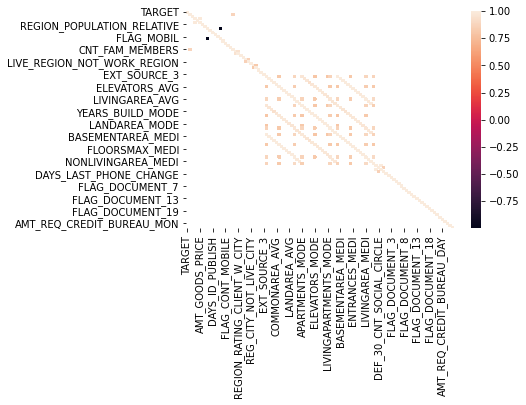

In [3]:
df_corr = df_train.drop(columns="SK_ID_CURR").corr()

ax = sns.heatmap(df_corr[(df_corr > 0.8) | (df_corr < -0.8)])

In [4]:
X = df_train.drop(columns=["TARGET", "SK_ID_CURR"])

y = df_train["TARGET"]

X = pd.get_dummies(X)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [6]:
with mlflow.start_run():
    mlflow.sklearn.autolog()
    
    n_estimators = 10
    
    gb_clf = GradientBoostingClassifier(loss='deviance',
                                        learning_rate=0.1,
                                        n_estimators=n_estimators,
                                        verbose=0)
    gb_clf.fit(X_train, y_train)
    gb_score = gb_clf.score(X_test, y_test)

In [7]:
# dtrain = xgb.DMatrix(data=X_train, label=y_train)

with mlflow.start_run():
    n_estimators = 10
    
    xgb_clf = xgb.XGBClassifier(n_estimators=n_estimators, verbosity=0)
    xgb_clf.fit(X_train, y_train)
    xgb_score = xgb_clf.score(X_test, y_test)

    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_metric("score", xgb_score)
    mlflow.xgboost.log_model(xgb_clf, 'model')

In [8]:
with mlflow.start_run():
    mlflow.sklearn.autolog()
    
    n_estimators = 10
    
    rf_clf = RandomForestClassifier(n_estimators=n_estimators, criterion="gini", max_depth=2, verbose=0)
    rf_clf.fit(X_train, y_train)
    rf_score = rf_clf.score(X_test, y_test)

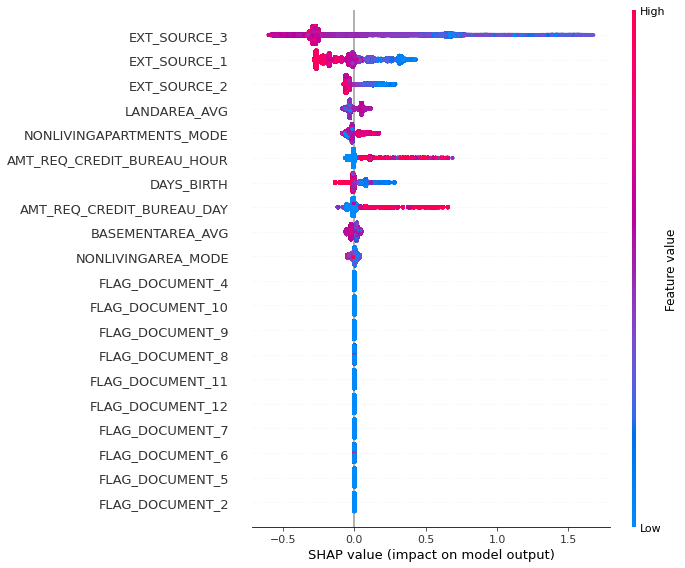

In [9]:
gb_shap_values = shap.TreeExplainer(gb_clf).shap_values(X_train)

f = plt.figure()
shap.summary_plot(gb_shap_values, X_train)

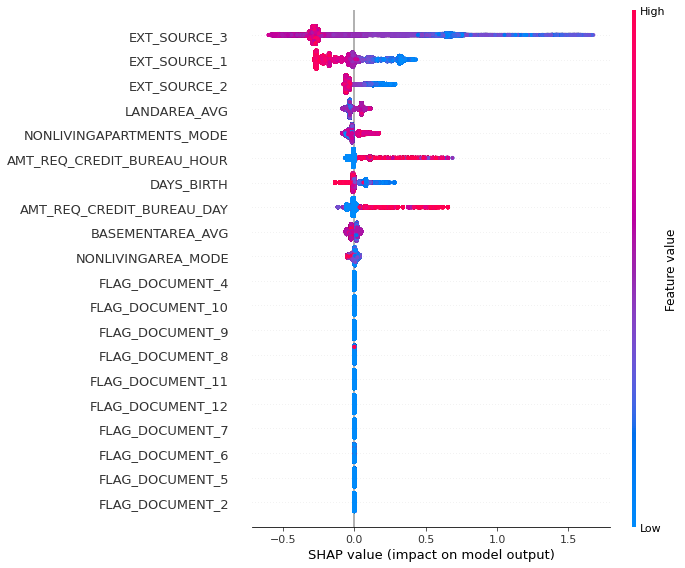

In [10]:
xgb_shap_values = shap.TreeExplainer(gb_clf).shap_values(X_train)

f = plt.figure()
shap.summary_plot(xgb_shap_values, X_train)

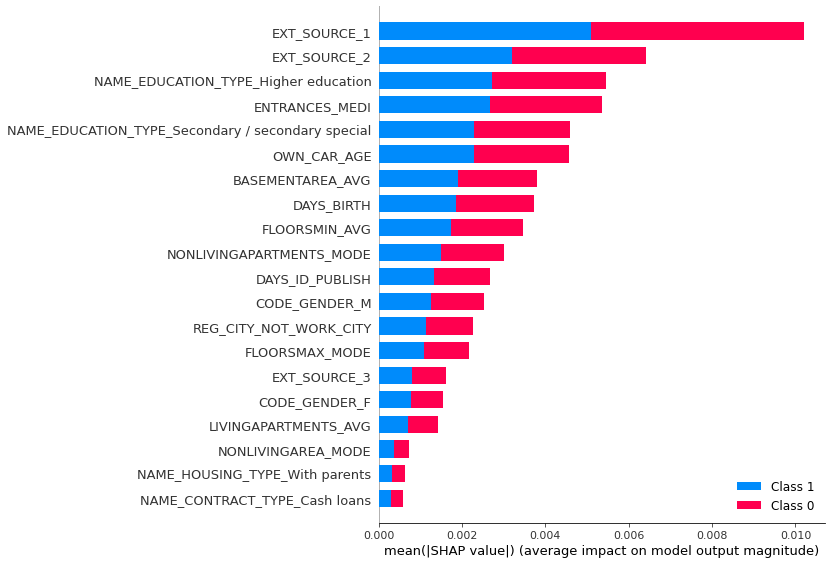

In [11]:
rf_shap_values = shap.TreeExplainer(rf_clf).shap_values(X_train)

f = plt.figure()
shap.summary_plot(rf_shap_values, X_train)

In [21]:
print({'columns' : list(X_train.iloc[0].index), 'data' : list(X_train.iloc[0].values)})

{'columns': ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE